In [1]:
import tensorflow as tf

tf.random.set_seed(42)

import os
import glob
import imageio
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 100

### Downloading The DATA

Total number of Images : 106
Focal : 138.88887889922103
Poses :  (106, 4, 4)


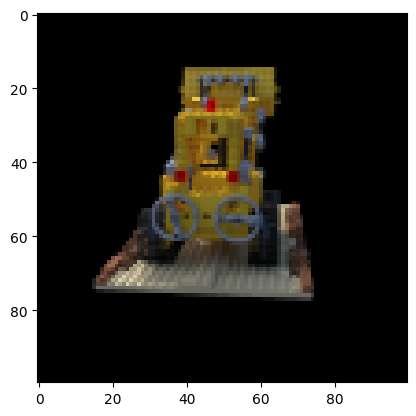

In [2]:
url = "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
file_name = "tiny_nerf_data.npz"


if not os.path.exists(file_name):
    data = keras.utils.get_file(fname=file_name, origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

print("Total number of Images :",num_images)
print("Focal :",focal)
print("Poses : ",poses.shape)

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

## Data pipeline

Now that you've understood the notion of camera matrix
and the mapping from a 3D scene to 2D images,
let's talk about the inverse mapping, i.e. from 2D image to the 3D scene.

We'll need to talk about volumetric rendering with ray casting and tracing,
which are common computer graphics techniques.
This section will help you get to speed with these techniques.

Consider an image with `N` pixels. We shoot a ray through each pixel
and sample some points on the ray. A ray is commonly parameterized by
the equation `r(t) = o + td` where `t` is the parameter, `o` is the
origin and `d` is the unit directional vector as shown in **Figure 6**.

| ![img](https://i.imgur.com/ywrqlzt.gif) |
| :---: |
| **Figure 6**: `r(t) = o + td` where t is 3 |

In **Figure 7**, we consider a ray, and we sample some random points on
the ray. These sample points each have a unique location `(x, y, z)`
and the ray has a viewing angle `(theta, phi)`. The viewing angle is
particularly interesting as we can shoot a ray through a single pixel
in a lot of different ways, each with a unique viewing angle. Another
interesting thing to notice here is the noise that is added to the
sampling process. We add a uniform noise to each sample so that the
samples correspond to a continuous distribution. In **Figure 7** the
blue points are the evenly distributed samples and the white points
`(t1, t2, t3)` are randomly placed between the samples.

| ![img](https://i.imgur.com/r9TS2wv.gif) |
| :---: |
| **Figure 7**: Sampling the points from a ray. |

**Figure 8** showcases the entire sampling process in 3D, where you
can see the rays coming out of the white image. This means that each
pixel will have its corresponding rays and each ray will be sampled at
distinct points.

| ![3-d rays](https://i.imgur.com/hr4D2g2.gif) |
| :---: |
| **Figure 8**: Shooting rays from all the pixels of an image in 3-D |

These sampled points act as the input to the NeRF model. The model is
then asked to predict the RGB color and the volume density at that
point.

| ![3-Drender](https://i.imgur.com/HHb6tlQ.png) |
| :---: |
| **Figure 9**: Data pipeline <br>
[Source: NeRF](https://arxiv.org/abs/2003.08934) |

In [3]:

def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)


def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)

In [4]:
# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]


# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

print("Train Images:",train_images.shape)
print("Validation Images :",val_images.shape)

print(" Train Poses :",train_poses.shape)
print("val Poses :",val_poses.shape)

Train Images: (84, 100, 100, 3)
Validation Images : (22, 100, 100, 3)
 Train Poses : (84, 4, 4)
val Poses : (22, 4, 4)


In [5]:
# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

## NeRF model

The model is a multi-layer perceptron (MLP), with ReLU as its non-linearity.

An excerpt from the paper:

*"We encourage the representation to be multiview-consistent by
restricting the network to predict the volume density sigma as a
function of only the location `x`, while allowing the RGB color `c` to be
predicted as a function of both location and viewing direction. To
accomplish this, the MLP first processes the input 3D coordinate `x`
with 8 fully-connected layers (using ReLU activations and 256 channels
per layer), and outputs sigma and a 256-dimensional feature vector.
This feature vector is then concatenated with the camera ray's viewing
direction and passed to one additional fully-connected layer (using a
ReLU activation and 128 channels) that output the view-dependent RGB
color."*

Here we have gone for a minimal implementation and have used 64
Dense units instead of 256 as mentioned in the paper.

In [6]:

def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The `tf.keras` model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)

## Training

The training step is implemented as part of a custom `keras.Model` subclass
so that we can make use of the `model.fit` functionality.

In [7]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]

test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []

### Nerf Callback

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) %10 == 0:
            loss = logs["loss"]
            loss_list.append(loss)
            test_recons_images, depth_maps = render_rgb_depth(
                model=self.model.nerf_model,
                rays_flat=test_rays_flat,
                t_vals=test_t_vals,
                rand=True,
                train=False,
            )

            # Plot the rgb, depth and the loss plot.
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
            ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
            ax[0].set_title(f"Predicted Image: {epoch+1:03d}")

            ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
            ax[1].set_title(f"Depth Map: {epoch+1:03d}")

            fig.savefig(f"images/{epoch+1:03d}.png")
            plt.show()
            plt.close()

checkpoint_filepath = '/content/nerf/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                save_weights_only=True,monitor='val_psnr',mode='max',save_best_only=True)

10/10 [==============================] - 32s 3s/step - loss: 0.0128 - psnr: 19.0833 - val_loss: 0.0132 - val_psnr: 18.8415
Epoch 33/100
10/10 [==============================] - 37s 3s/step - loss: 0.0126 - psnr: 19.1485 - val_loss: 0.0134 - val_psnr: 18.7644
Epoch 34/100
10/10 [==============================] - 36s 3s/step - loss: 0.0122 - psnr: 19.2575 - val_loss: 0.0127 - val_psnr: 19.0035
Epoch 35/100
10/10 [==============================] - 36s 3s/step - loss: 0.0117 - psnr: 19.4464 - val_loss: 0.0123 - val_psnr: 19.1611
Epoch 36/100
10/10 [==============================] - 36s 3s/step - loss: 0.0115 - psnr: 19.5547 - val_loss: 0.0117 - val_psnr: 19.3932
Epoch 37/100
10/10 [==============================] - 36s 3s/step - loss: 0.0112 - psnr: 19.6600 - val_loss: 0.0116 - val_psnr: 19.4188
Epoch 38/100
10/10 [==============================] - 36s 3s/step - loss: 0.0113 - psnr: 19.6247 - val_loss: 0.0110 - val_psnr: 19.7158
Epoch 39/100
10/10 [==============================] - 36s 3s/

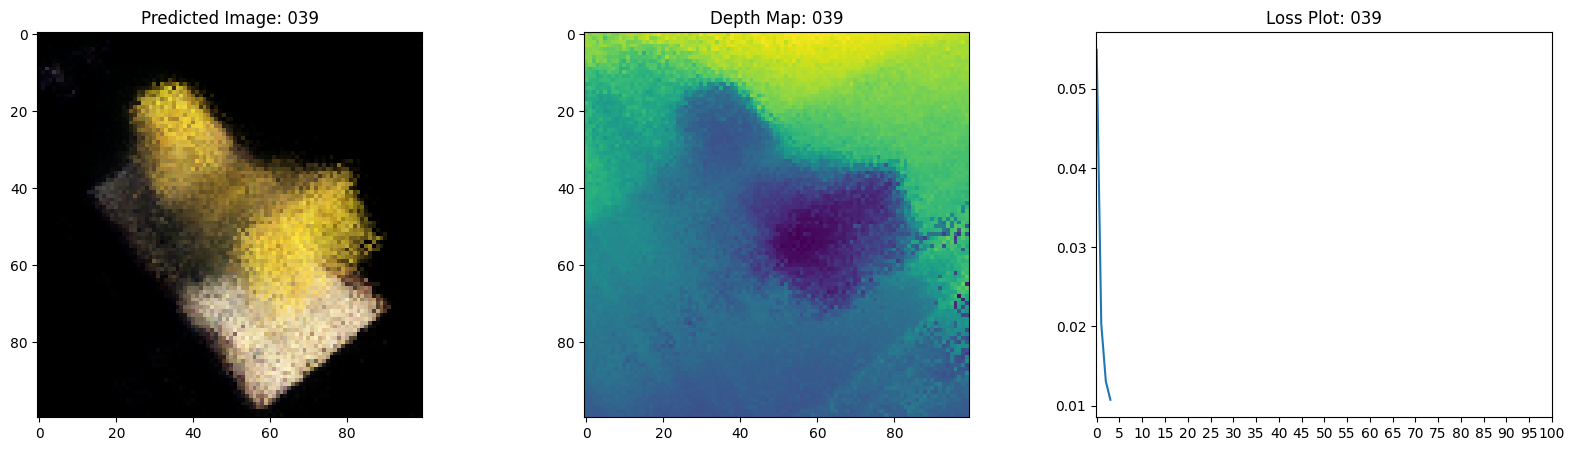

10/10 [==============================] - 37s 4s/step - loss: 0.0107 - psnr: 19.8458 - val_loss: 0.0112 - val_psnr: 19.6874
Epoch 41/100
10/10 [==============================] - 36s 3s/step - loss: 0.0104 - psnr: 19.9714 - val_loss: 0.0115 - val_psnr: 19.4987
Epoch 42/100
10/10 [==============================] - 37s 4s/step - loss: 0.0105 - psnr: 19.9496 - val_loss: 0.0110 - val_psnr: 19.7596
Epoch 43/100
10/10 [==============================] - 36s 3s/step - loss: 0.0100 - psnr: 20.1501 - val_loss: 0.0107 - val_psnr: 19.7682
Epoch 44/100
10/10 [==============================] - 36s 3s/step - loss: 0.0101 - psnr: 20.0979 - val_loss: 0.0107 - val_psnr: 19.7869
Epoch 45/100
10/10 [==============================] - 35s 3s/step - loss: 0.0098 - psnr: 20.2364 - val_loss: 0.0103 - val_psnr: 20.0214
Epoch 46/100
10/10 [==============================] - 34s 3s/step - loss: 0.0097 - psnr: 20.3001 - val_loss: 0.0101 - val_psnr: 20.1383
Epoch 47/100
10/10 [==============================] - 33s 3s/

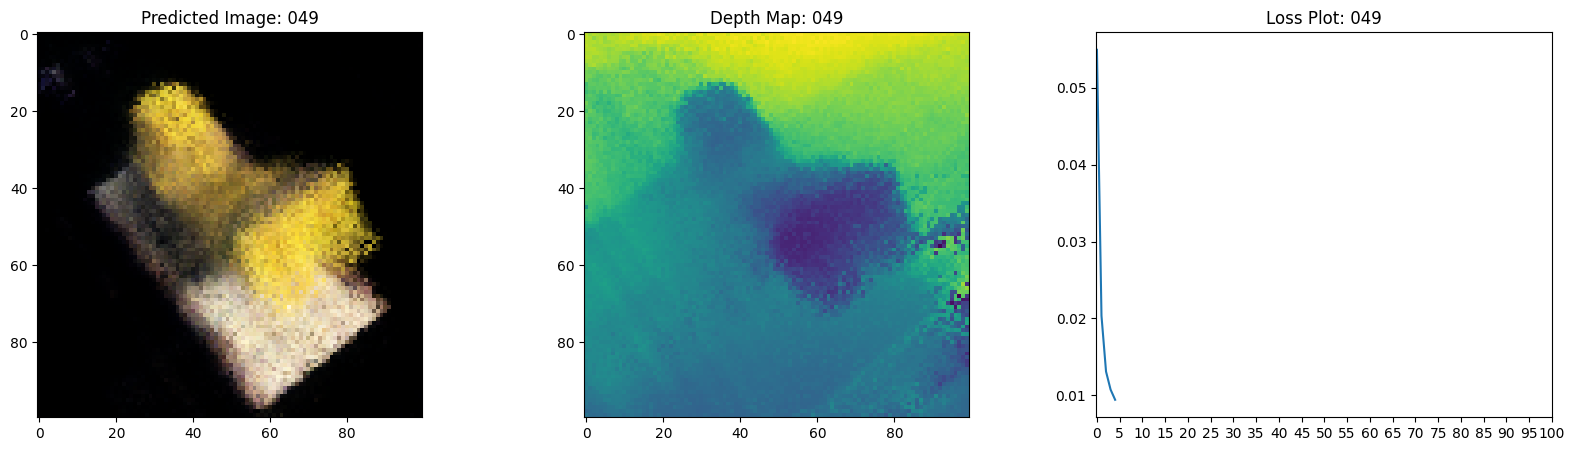

10/10 [==============================] - 38s 4s/step - loss: 0.0094 - psnr: 20.4107 - val_loss: 0.0102 - val_psnr: 19.9939
Epoch 51/100
10/10 [==============================] - 33s 3s/step - loss: 0.0092 - psnr: 20.4948 - val_loss: 0.0097 - val_psnr: 20.2236
Epoch 52/100
10/10 [==============================] - 36s 3s/step - loss: 0.0090 - psnr: 20.5871 - val_loss: 0.0098 - val_psnr: 20.1718
Epoch 53/100
10/10 [==============================] - 35s 3s/step - loss: 0.0089 - psnr: 20.6421 - val_loss: 0.0101 - val_psnr: 20.0479
Epoch 54/100
10/10 [==============================] - 37s 3s/step - loss: 0.0090 - psnr: 20.6042 - val_loss: 0.0094 - val_psnr: 20.3179
Epoch 55/100
10/10 [==============================] - 32s 3s/step - loss: 0.0089 - psnr: 20.6657 - val_loss: 0.0092 - val_psnr: 20.4194
Epoch 56/100
10/10 [==============================] - 33s 3s/step - loss: 0.0088 - psnr: 20.6892 - val_loss: 0.0099 - val_psnr: 20.1871
Epoch 57/100
10/10 [==============================] - 35s 3s/

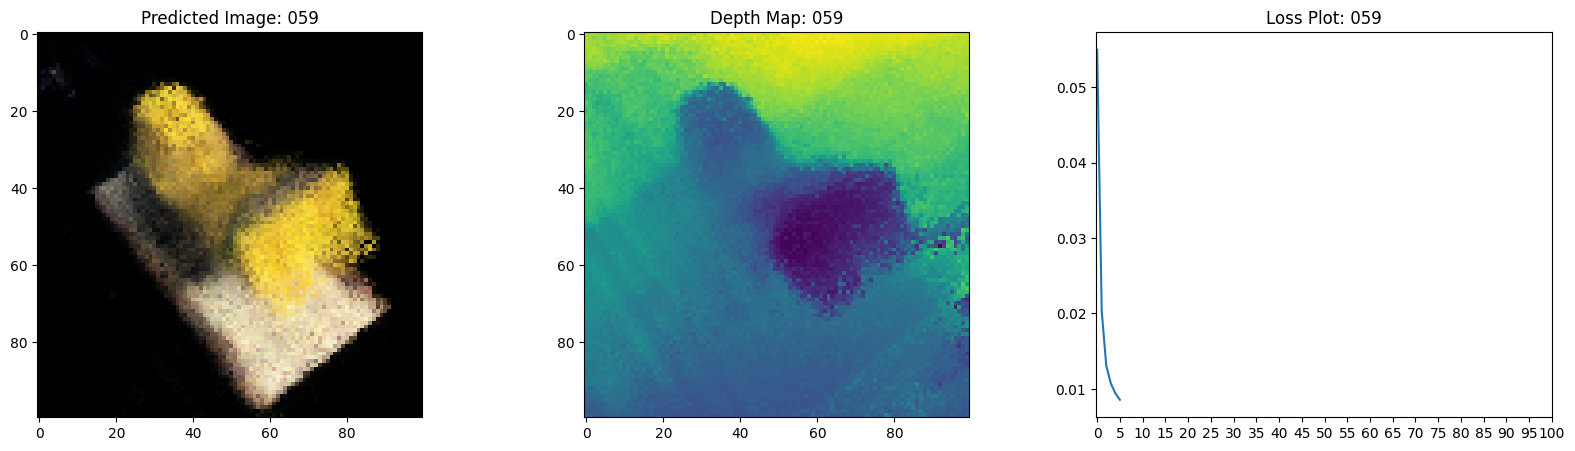

10/10 [==============================] - 38s 4s/step - loss: 0.0086 - psnr: 20.8103 - val_loss: 0.0095 - val_psnr: 20.3056
Epoch 61/100
10/10 [==============================] - 33s 3s/step - loss: 0.0084 - psnr: 20.9306 - val_loss: 0.0094 - val_psnr: 20.4195
Epoch 62/100
10/10 [==============================] - 36s 3s/step - loss: 0.0083 - psnr: 20.9676 - val_loss: 0.0090 - val_psnr: 20.5702
Epoch 63/100
10/10 [==============================] - 37s 3s/step - loss: 0.0082 - psnr: 21.0039 - val_loss: 0.0086 - val_psnr: 20.7523
Epoch 64/100
10/10 [==============================] - 36s 3s/step - loss: 0.0082 - psnr: 21.0258 - val_loss: 0.0090 - val_psnr: 20.5967
Epoch 65/100
10/10 [==============================] - 36s 3s/step - loss: 0.0081 - psnr: 21.0509 - val_loss: 0.0090 - val_psnr: 20.5586
Epoch 66/100
10/10 [==============================] - 32s 3s/step - loss: 0.0081 - psnr: 21.1012 - val_loss: 0.0089 - val_psnr: 20.5845
Epoch 67/100
10/10 [==============================] - 32s 3s/

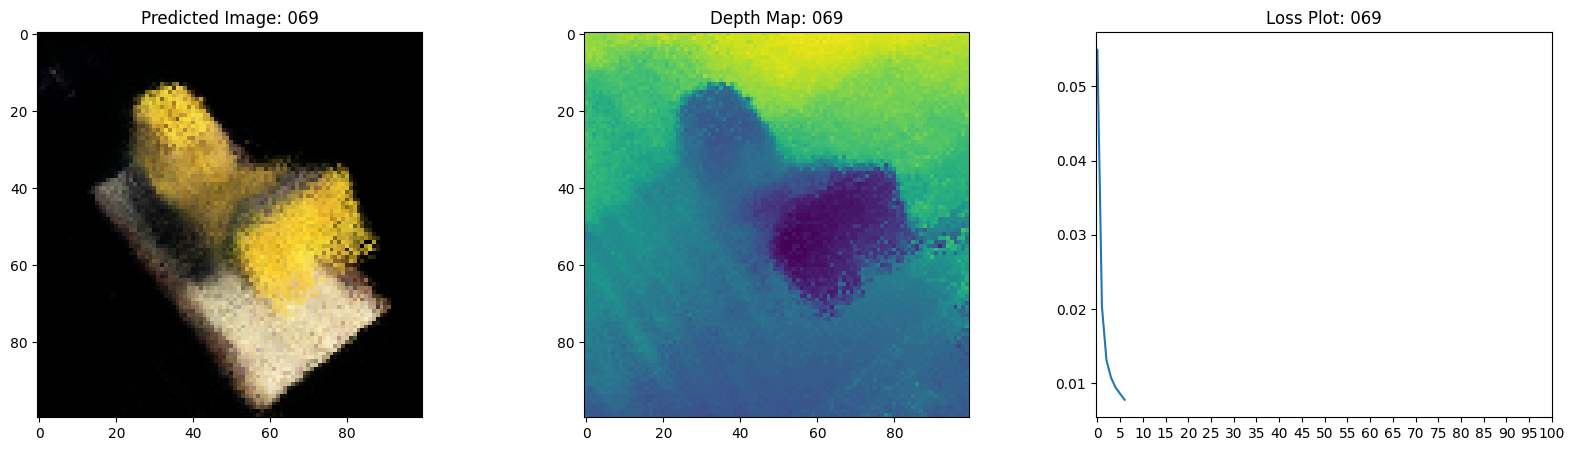

10/10 [==============================] - 37s 4s/step - loss: 0.0078 - psnr: 21.2504 - val_loss: 0.0085 - val_psnr: 20.8429
Epoch 71/100
10/10 [==============================] - 33s 3s/step - loss: 0.0079 - psnr: 21.1857 - val_loss: 0.0084 - val_psnr: 20.9073
Epoch 72/100
10/10 [==============================] - 36s 3s/step - loss: 0.0079 - psnr: 21.1789 - val_loss: 0.0083 - val_psnr: 20.9259
Epoch 73/100
10/10 [==============================] - 36s 3s/step - loss: 0.0076 - psnr: 21.3295 - val_loss: 0.0086 - val_psnr: 20.7443
Epoch 74/100
10/10 [==============================] - 36s 3s/step - loss: 0.0076 - psnr: 21.3264 - val_loss: 0.0081 - val_psnr: 20.9742
Epoch 75/100
10/10 [==============================] - 37s 4s/step - loss: 0.0077 - psnr: 21.2856 - val_loss: 0.0079 - val_psnr: 21.0900
Epoch 76/100
10/10 [==============================] - 31s 3s/step - loss: 0.0076 - psnr: 21.3119 - val_loss: 0.0084 - val_psnr: 20.8180
Epoch 77/100
10/10 [==============================] - 36s 3s/

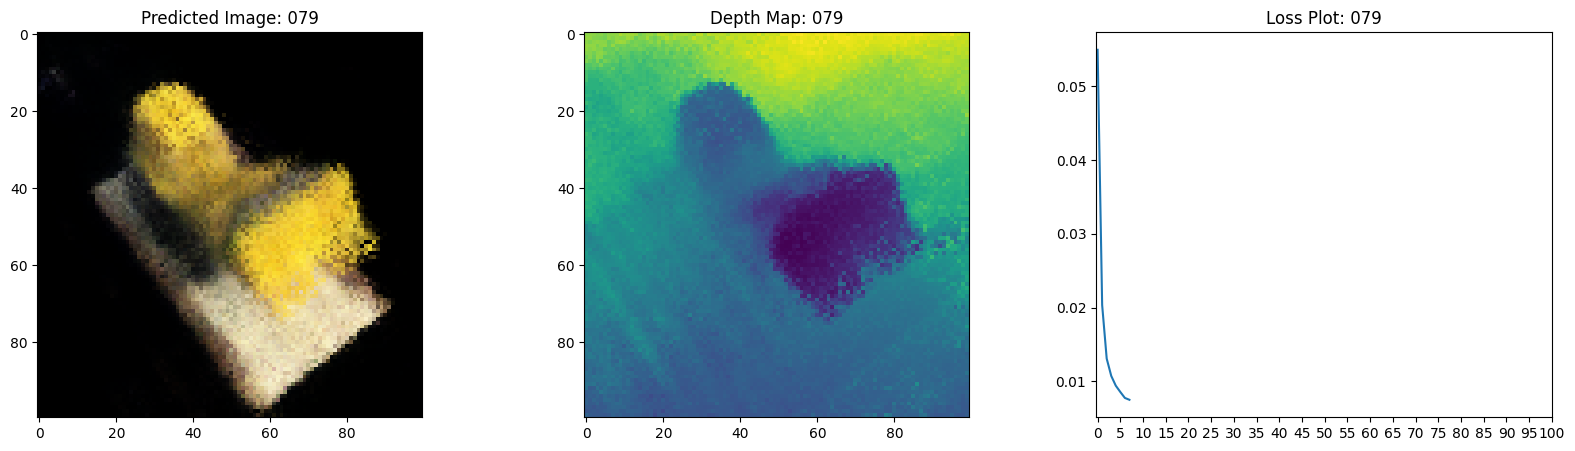

10/10 [==============================] - 37s 4s/step - loss: 0.0075 - psnr: 21.3930 - val_loss: 0.0076 - val_psnr: 21.2898
Epoch 81/100
10/10 [==============================] - 31s 3s/step - loss: 0.0074 - psnr: 21.4217 - val_loss: 0.0081 - val_psnr: 20.9967
Epoch 82/100
10/10 [==============================] - 36s 3s/step - loss: 0.0073 - psnr: 21.5385 - val_loss: 0.0081 - val_psnr: 21.0765
Epoch 83/100
10/10 [==============================] - 37s 4s/step - loss: 0.0073 - psnr: 21.5626 - val_loss: 0.0077 - val_psnr: 21.2132
Epoch 84/100
10/10 [==============================] - 36s 3s/step - loss: 0.0073 - psnr: 21.5469 - val_loss: 0.0081 - val_psnr: 21.0045
Epoch 85/100
10/10 [==============================] - 33s 3s/step - loss: 0.0073 - psnr: 21.5011 - val_loss: 0.0080 - val_psnr: 21.0086
Epoch 86/100
10/10 [==============================] - 32s 3s/step - loss: 0.0073 - psnr: 21.5094 - val_loss: 0.0081 - val_psnr: 20.9731
Epoch 87/100
10/10 [==============================] - 37s 4s/

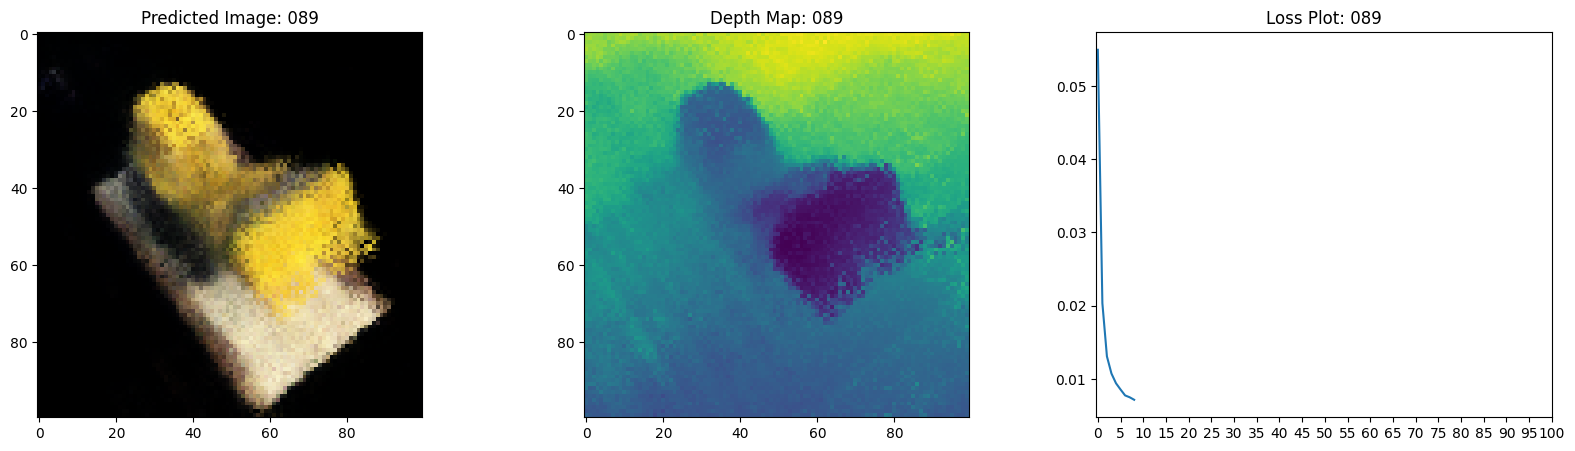

10/10 [==============================] - 38s 4s/step - loss: 0.0072 - psnr: 21.5986 - val_loss: 0.0080 - val_psnr: 20.9949
Epoch 91/100
10/10 [==============================] - 34s 3s/step - loss: 0.0072 - psnr: 21.5602 - val_loss: 0.0082 - val_psnr: 20.9388
Epoch 92/100
10/10 [==============================] - 35s 3s/step - loss: 0.0071 - psnr: 21.6458 - val_loss: 0.0079 - val_psnr: 21.0939
Epoch 93/100
10/10 [==============================] - 36s 3s/step - loss: 0.0070 - psnr: 21.6719 - val_loss: 0.0077 - val_psnr: 21.2558
Epoch 94/100
10/10 [==============================] - 36s 3s/step - loss: 0.0069 - psnr: 21.7834 - val_loss: 0.0077 - val_psnr: 21.3069
Epoch 95/100
10/10 [==============================] - 33s 3s/step - loss: 0.0069 - psnr: 21.7490 - val_loss: 0.0077 - val_psnr: 21.2609
Epoch 96/100
10/10 [==============================] - 36s 3s/step - loss: 0.0069 - psnr: 21.7447 - val_loss: 0.0075 - val_psnr: 21.4084
Epoch 97/100
10/10 [==============================] - 36s 3s/

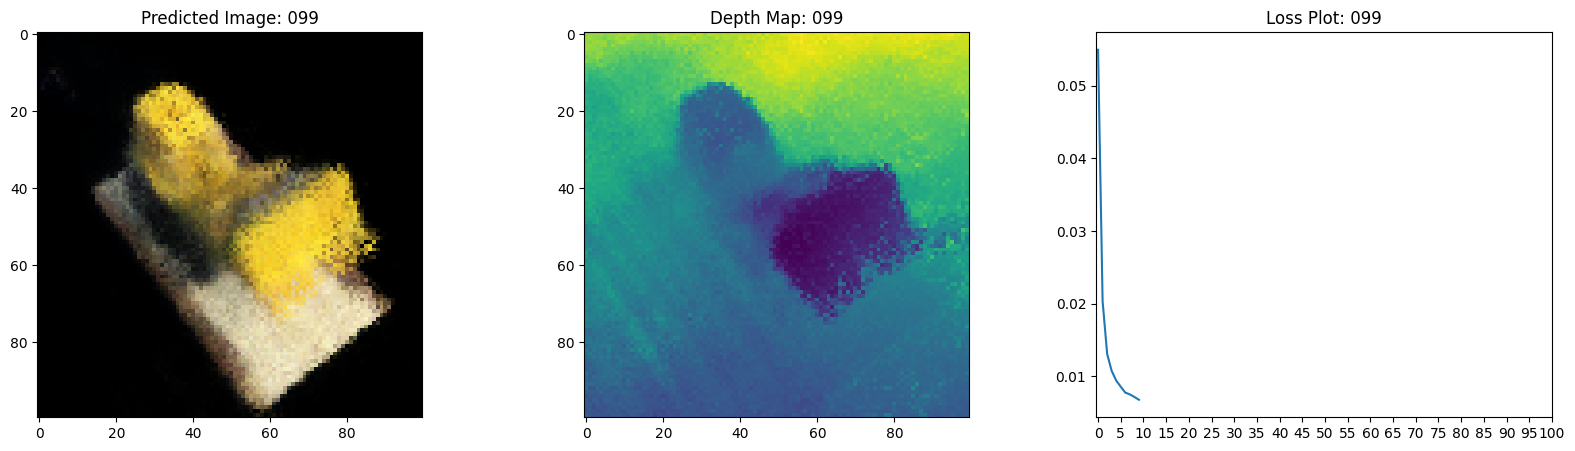

10/10 [==============================] - 38s 4s/step - loss: 0.0068 - psnr: 21.8528 - val_loss: 0.0076 - val_psnr: 21.3364


In [9]:
num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor(),model_checkpoint_callback],
    steps_per_epoch=split_index // BATCH_SIZE,
)

#### Inference

In this section, we ask the model to build novel views of the scene.
The model was given `106` views of the scene in the training step. The
collections of training images cannot contain each and every angle of
the scene. A trained model can represent the entire 3-D scene with a
sparse set of training images.

Here we provide different poses to the model and ask for it to give us
the 2-D image corresponding to that camera view. If we infer the model
for all the 360-degree views, it should provide an overview of the
entire scenery from all around.

In [10]:
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)
model = NeRF(nerf_model)
model.load_weights(checkpoint_filepath)


1/1 [==============================] - 2s 2s/step


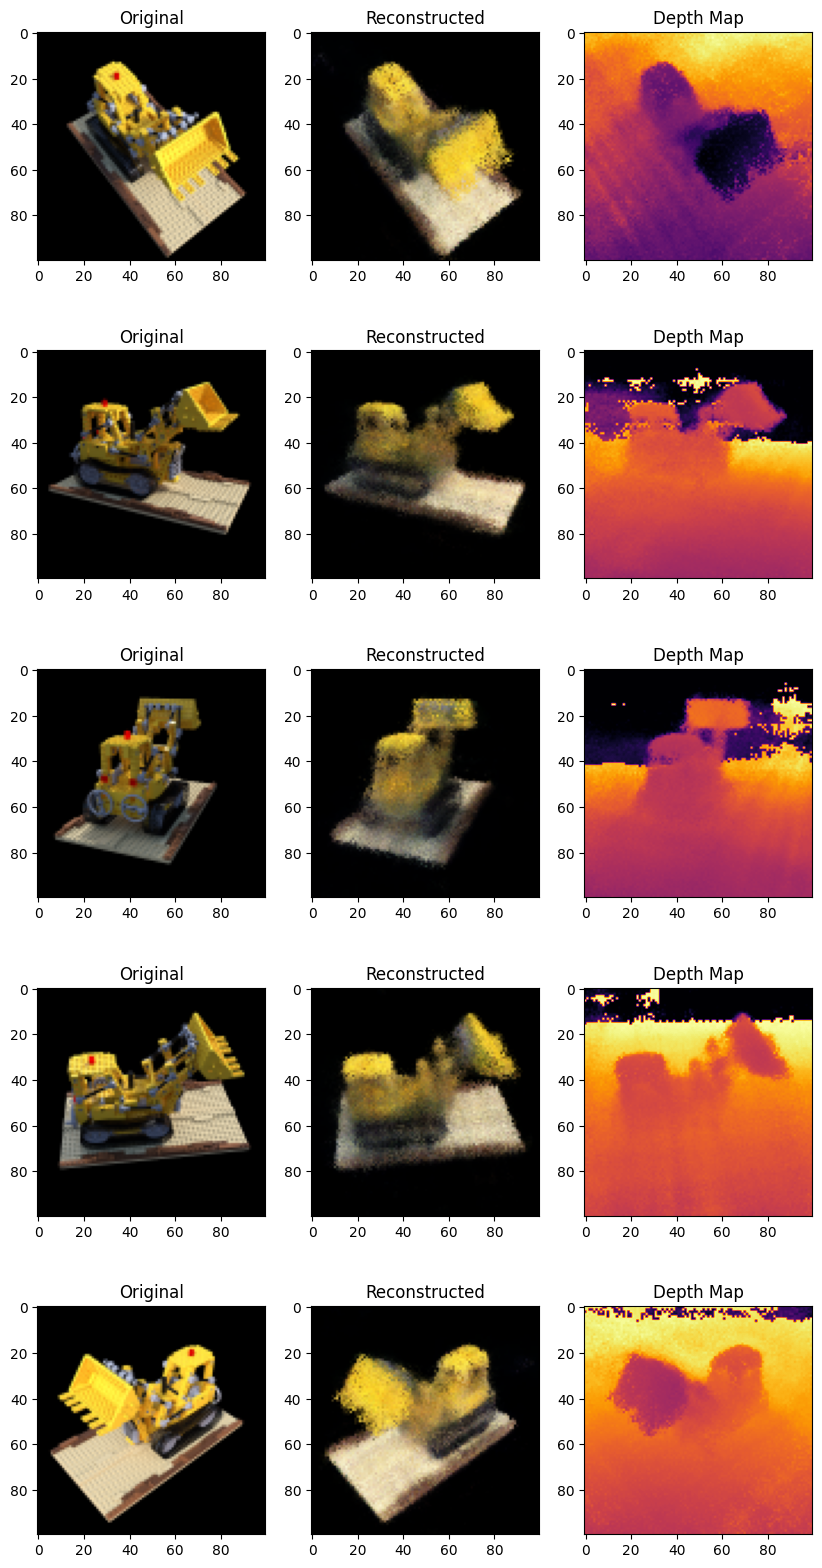

In [11]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(
        keras.utils.array_to_img(depth_map[..., None]), cmap="inferno"
    )
    ax[2].set_title("Depth Map")

### Render 3D

In [ ]:

def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

6it [00:00, 26.50it/s]

1/1 [==============================] - 1s 1s/step


14it [00:02,  6.30it/s]

1/1 [==============================] - 1s 1s/step


22it [00:04,  5.20it/s]

1/1 [==============================] - 1s 1s/step


30it [00:06,  4.86it/s]

1/1 [==============================] - 1s 1s/step


37it [00:10,  3.30it/s]

1/1 [==============================] - 2s 2s/step


48it [00:13,  3.88it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('rgb_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)